In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from tqdm import tqdm, tqdm_gui
import matplotlib.pyplot as plt
from PIL import Image
import time
from sklearn.model_selection import train_test_split
import h5py
from datetime import datetime
%load_ext watermark

In [3]:
%watermark

2018-07-25T12:04:51-04:00

CPython 3.6.4
IPython 6.2.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


The images used in this notebook are from the ILSVRC images database. Specifically it is from the 2013 object detection challenge where the specific image classes are 
* **n01503061** - **Bird** \[1,445 Pictures\]
* **n02099602** - **Dog** \[1,069 Pictures\] (Specifically Golden Retriever in this case as the datbase contains several instances of different dog breeds)
* **n02958343** - **Car** \[839 Pictures\]
* **n04330267** - **Stove** \[1,196 Pictures\]

We have our images in a separate directory. The directory contains a folder for 1,445 images of birds, 1,069 images of dogs, 839 images of cars, and 1,196 images of stoves. We need to take all those images and:
1. pixelate them - that is turn each image into a H x W x C array
2. Reshape them - Our CNN will expect a standardized input shape, therefore we must shrink, stretch, enlarge, compact or our images to meet this input requirement
3. Create one massive m X 300 X 300 x C array. That is an array with m number of pixelized image examples of shape 300 x 300 x C. In this case C is 3, representing the red,green, blue (RGB) valuese of each pixel
4. Store the converted data in a h5 file - due the amount of training data (currently 4549) this results in 4549x500x500x3 = 3.4 Billion number array! Assuming a data type of numpy float32, this breaks down to 3.4 billion x 32 / 8 = approx 13.6 GB. Currently my system has 16GB of ram so it could handle this, but it isn't ideal

We will create a class that will help us manage all of our data

In [2]:
class load_training_data():
    def __init__(self,directory = '/home/scott/Pictures/Training Pictures/'):
        
        print('Navigating to Directory and Compiling Images')
        
        #Initialize some empty variables
        self.i = 0
        self.training_data_paths = []
        self.training_labels = []
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        
        try:
            #Change to the directory with the images
            os.chdir(directory)
            #Make a list of all the subdirectories of different picture types
            self.sub_directories = os.listdir()
        except Exception as e:
            print(e)
            print('Please Enter a Valid Directory')
            
            
            
        for pos, d in enumerate(self.sub_directories):
            #Make a list of all the image names in the current sub directory
            images = os.listdir(d)
            #Create a list of full path names for every image in the current sub directory
            self.training_data_paths.extend([os.path.join(directory, d+'/'+img) for img in images])
            #Encode the target label for the current picture type
            #Dogs = (1,0,0,0) | Birds = (0,1,0,0) | Stove = (0,0,1,0) | Cars = (0,0,0,1)
            encoding = np.zeros(len(self.sub_directories))
            encoding[pos] = 1
            #Extend the list of one hot encoded training labels
            self.training_labels.extend([encoding]*len(os.listdir(d)))
        
        
        
        try:    
            #Assert that the total number one hot encoded target labels equals the total of training examples
            assert len(self.training_data_paths) == len(self.training_labels)
        except AssertionError:
            raise(AssertionError( 'Number of Trainining Examples m = {} Does Not Match Number of Training Labels (m) = {}'.format(len(self.training_data), len(self.training_labels)) ))
        print('Finished Compiling Images')
      
    
    
    def process_images(self):
        training_images = []
        
        print('\nProcessing Images into n-Dimensional Arrays')
        print('------------------------------------------------')
        #Create a list of the 3-dimensional numpy array of pixel values for each image
        training_images.extend(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB) for path in self.training_data_paths)
        #Delete unncessary variables for RAM allocation control
        del self.training_data_paths
        
        #Show the average height and width in pixels of all images in the training data
        height = np.mean([d.shape[0] for d in training_images])
        width = np.mean([d.shape[1] for d in training_images])
        print('\naverage image height is',height)
        print('average image width is', width)
        #Delete unncessary variables for RAM allocation control
        del height
        del width
        
        print('\nreshaping images to 300x300x3')
        print('------------------------------------------------')
        #Reshape all images to 300x300x3
        training_images_reshaped = [cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA) for img in training_images]
        #Delete unncessary variables for RAM allocation control
        del training_images
        
        print('\nCreating {} x 300 x 300 x 3 array'.format(len(self.training_labels)))
        print('------------------------------------------------')
        #Create a m X 300 X 300 X 3 array of all training data --> m being the total number of all pics
        tensor_data = np.vstack([img for img in training_images_reshaped]).reshape(len(self.training_labels),300,300,3)
        #Create a m X 1 X 4 array of all training labels
        self.training_labels = np.vstack([label for label in self.training_labels]).reshape(len(self.training_labels),1,len(self.sub_directories))
        #Delete unncessary variables for RAM allocation control
        del training_images_reshaped
        
        print('\nExecuting Train Test Split')
        print('------------------------------------------------')
        #Create Train Test Splits
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(tensor_data, self.training_labels, test_size = 0.3, random_state = 100)
        print('\nDone Creating Training and Testing Data at 70/30 Split!')
        #Delete unncessary variables for RAM allocation control
        del self.training_labels
        
        return self
        
    def next_batch(self, batch_size):
        #Method for batch feeding into model if RAM capacity is sufficient to load data all at once
        x = self.X_train[self.i:self.i+ batch_size]
        y = self.y_train[self.i:self.i+ batch_size]
        self.i = (self.i + batch_size) % len(self.X_train)
        return x,y
    
    def write_h5(self):
        print('\nWriting data to HDF5')
        print('------------------------------------------------')
        # Method to write transformed data to hdf5
        hf = h5py.File('data.h5', 'w')
        
        hf.create_dataset('X_train', data=np.divide(self.X_train,255))
        hf.create_dataset('X_test', data=np.divide(self.X_test,255))
        hf.create_dataset('y_train', data=self.y_train)
        hf.create_dataset('y_test', data=self.y_test)
        hf.close()
        print('\nFinished Writing h5 in {}'.format(os.getcwd()))

In [4]:
load_training_data().process_images().write_h5()

Navigating to Directory and Compiling Images
Finished Compiling Images

Processing Images into n-Dimensional Arrays
------------------------------------------------

average image height is 387.68322708287536
average image width is 454.8964607606067

reshaping images to 300x300x3
------------------------------------------------

Creating 4549 x 300 x 300 x 3 array
------------------------------------------------

Executing Train Test Split
------------------------------------------------

Done Creating Training and Testing Data at 70/30 Split!

Writing data to HDF5
------------------------------------------------

Finished Writing h5 in /home/scott/Pictures/Training Pictures


During processing, I definitely pushed the limits of my ram. I adjusted my computer's swap level to allow my system to process from hard drive when needed instead of causing a stack overflow. But after writing the data to a h5 file, all arrays are wiped from memory (RAM) and now on disk.

In [3]:
data = h5py.File('/home/scott/Pictures/Training Pictures/data.h5', 'r')

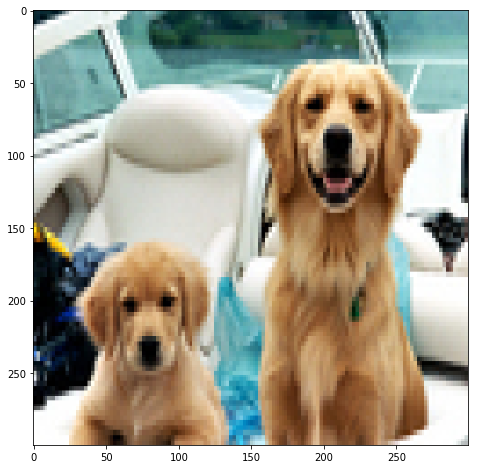

[[[0.05490196 0.16078431 0.18823529]
  [0.05490196 0.16078431 0.18823529]
  [0.05882353 0.16862745 0.20392157]
  ...
  [0.43921569 0.67058824 0.70588235]
  [0.43921569 0.6745098  0.70588235]
  [0.43921569 0.6745098  0.70588235]]

 [[0.05490196 0.16078431 0.18823529]
  [0.05490196 0.16078431 0.18823529]
  [0.05882353 0.16862745 0.20392157]
  ...
  [0.43921569 0.67058824 0.70588235]
  [0.43921569 0.6745098  0.70588235]
  [0.43921569 0.6745098  0.70588235]]

 [[0.05490196 0.16078431 0.18823529]
  [0.05490196 0.16078431 0.18823529]
  [0.05882353 0.16862745 0.20392157]
  ...
  [0.43921569 0.67058824 0.70588235]
  [0.43921569 0.6745098  0.70588235]
  [0.43921569 0.6745098  0.70588235]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         0.99607843]
  ...
  [0.72941176 0.74901961 0.75294118]
  [0.71764706 0.73333333 0.7372549 ]
  [0.71764706 0.73333333 0.7372549 ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


In [5]:
plt.figure(figsize = (15,8))
plt.imshow(data['X_train'][300])
plt.show()
print(data['X_train'][300])

As we can see, the data is still extractable from the hdf5 file and is still scaled in a normalized fashion \[0-1\]. Even though it is normalized, the image still renders properly. Take note how grainy the image is. This is due to reshaping of all images to a 300x300x3 array. 

In [4]:
X_train, y_train = data['X_train'], data['y_train']

In [5]:
y_train_v1 = [y.reshape(-1) for y in y_train]

Now let's visually inspect the split of the training data to ensure that one or more of the classes isn't improperly imbalanced with respect to all other classes. If it is, then we can just use a different random state in the train test split function in the load_data class

In [8]:
categories = ['dog','bird','stove','car']

In [9]:
y = np.unique([y.argmax() for y in y_train], return_counts = True)

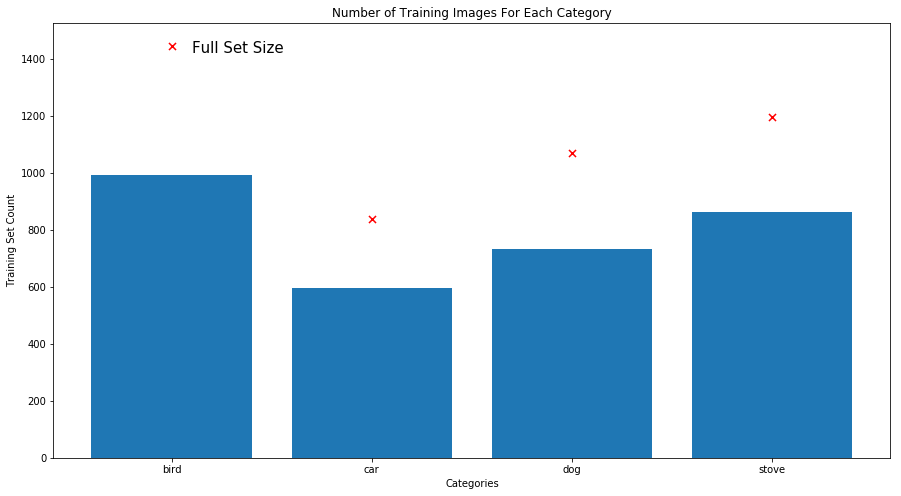

In [10]:
plt.figure(figsize = (15,8))
plt.bar(categories, y[1])
plt.xlabel('Categories')
plt.ylabel('Training Set Count')
plt.title('Number of Training Images For Each Category')
plt.scatter(range(4), [1445,839,1069,1196], marker = 'x', color = 'r',s = 50)
plt.text(0.1, 1420, 'Full Set Size',size=15)
plt.show()

The Train Test split appears to be reasonable. No one class is more overloaded than the other with respect to how many images there were in each class total. Now we can start building our tensorflow graph for a Convolutional Neural Network (CNN)

# Convolutional and Pooling Filter

#### Convolution
---------------------------------------
Also known as a filter, is a (m x n) matrix that is overlaid an (M x N) image. The filter (m x n) < the image (M x N). The image below helps illustrate this notion

<img src="images/convolve.png" width="500" />

The top left corner of filter K is initially aligned with the top left corner of image I. The values of I are the pixel values for the image. The overlaid filter values are then multiplied with their corresponding pixel cell, and then all the values are summed together. The filter is then slid over by one column and the operation starts again. Once the filter has gone as far right as possible, it then resets to the left and shifts down one row. It then repeats the same process until it has convolved on the whole image. As shown, the resulting output shrinks the image by a factor of:
> (n1 - f1 + 1) x (n2 -f2 + 1)

Where n1 & n2 is the pixel height & width of the image respectively, f1 & f2 are the height and width of the filter respectively. As seen above, the image is a 7x7 image with a 3x3 filter being applied. The resulting output is:
> (7 - 3 + 1) x (7 - 3 + 1) = 5x5 resulting output

So what is this filter doing? It is basically an edge detector/feature extractor. Since the filter is multiplying the pixel values and summing the result, the areas with high pixel intensity will be amplified and areas with low pixel intensity will be attenuated. The orientation of this amplification/attenuation depends on the orientation of the filter. Let's look at a Vertical Edge Detector example taken from Andrew Ng's CNN deep learning Course for an illustration of whats going on

<img src="images/edge_detect.png" width="800" height="800"/>

As illustrated above, the first 3 columns have pixel intensity 10 and the last 3 have pixel intensity 0. This results in the image seen below it. The left side of the image is white where the right side of the image is gray, with an obvious edge boundary between the two. As the filter convolves around the image, it reduces to pixel values to 0 everywhere except for where the edge existed between the two pixel intensities. This filter is a vertical edge detector. If this filter was rotated 90 degrees, it would then become a horizontal edge detector. Let's apply this filter on one of our images

##### TF Placeholders

In [6]:
x = tf.placeholder(dtype = tf.float64, shape = [None, 300, 300, 3], name = 'X')
y = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None, 4], name = 'Y'), dtype = tf.int32)

Construct the following filter: Vertical Edge Detector

|   |   |   |
|---|---|---|
|  1 | 0  | -1  |
|  1 |  0 |   -1|
|  1 |   0| -1  |

Construct the following filter: Horizontal Edge Detector

|   |   |   |
|---|---|---|
|  1 | 1  | 1  |
|  0 |  0 |   0|
|  -1 |   -1| -1  |

In [7]:
filters = np.zeros(shape=(3,3,3,2), dtype = np.float64)
filters[:,2,:,0] = 1 #vertical line
filters[:,0,:,0] = -1
filters[2,:,:,1] = 1 #horizontal line
filters[0,:,:,1] = -1

##### Create Convolutional Graph

In [8]:
with tf.name_scope('Convolutional_Layers'):
    convolution = tf.nn.conv2d(input = x, filter = filters, strides=[1,1,1,1], padding = 'SAME', name = 'Conv_1')

In [9]:
with tf.name_scope('Max_Pool'):
    max_pool = tf.nn.max_pool(convolution, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID', name = 'Max_Pool',)

In [10]:
with tf.Session() as sess:
    output_con = sess.run(convolution, feed_dict = {x:X_train[0:2]})
    output_pool = sess.run(max_pool, feed_dict = {x:X_train[0:2]})
    

##### Run the CNN and show the output from each filter
------------------------------------------------------
After running an image through the CNN we can see the result of the vertical and horizontal filter on the original image

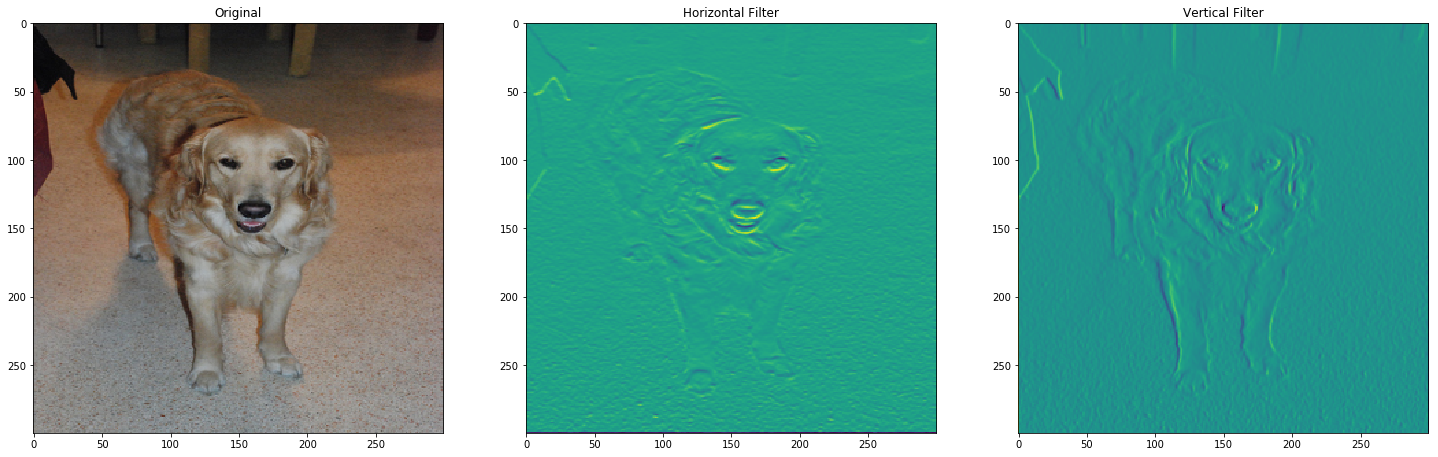

In [11]:
plt.subplots(nrows = 1, ncols = 3, figsize = (25,25))
ax1 = plt.subplot(131)
plt.imshow(X_train[0])
ax1.set_title('Original')

ax2 = plt.subplot(132)
plt.imshow(output_con[0,:,:,1])
ax2.set_title('Horizontal Filter')

ax3 = plt.subplot(133)
plt.imshow(output_con[0,:,:,0])
ax3.set_title('Vertical Filter')
plt.savefig('images/conv_filter.jpeg', bbox_layout = 'tight')
plt.show()


The images are fed in as 300x300x3 arrays. Notice that the output of these images retain this 300x300 shape. This is due to padding

In [18]:
output_con[0,:,:,1].shape

(300, 300)

<img src="images/pad.png" width="800" height="800"/>

As explained above, padding is the act of taking our (M x N) image (300x300) in this case and adding extra rows and columns of 0 values around it. This is done because when convolving the filter around the image, the middle pixel values are are involved in several instances of the convolutional process. The pixels on the sides however are convolved on less frequently due to their position at the borders. Because of this, a lot of information at the borders are lost. By adding 0 padding, we are able to convolve on these border pixesl more often, thus preserving information at the borders. Padding also serves as a way to control output of the convolutional layers. If we need a specific output size, we can ensure we get it by incorporating padding

#### Pooling Layer
-----------------------------------------
A very common practice after feeding an image into a convolutional layer (applying the convolutional filter) is to then feed that output into what is known as a **Pooling Layer**. This layer acts as yet another fitler. There are two types of pooling layers; Max pooling or Average pooling. I'll discuss Max pooling, but the idea of average pooling can be inferred from the explanation 

<img src="images/pool.png" width="500" height="500"/>

A max pool filter simply overlays a filter on the image as shown above and simply returns the largest value in the filter. The filter is then slid over by a predetermined amount of cols and the step is repeated. This pooling layer is used for 2 different reasons
1. It reduces the dimensionality of the data. The pool layer is a non trainable layer that simply takes the highest value in an array. As seen above we are reducing the size of our image (in that example) by 75%. This well have great computational effects during training. However there is an inherent issue with this. We are throwing away 3/4 of our data. 
2. The model needs to be invariant to small perturbations in the data. The model shouldn't be trained so precisely that it looks for an exact pixel in an exact location. It should generalize well to any image with the object of interest in any orientation, size and shape. The pooling layer injects this variance into the model. The convolution layer tries to identify some important structure in some region of the data while the pooling layer obscures the exact location of this structure.

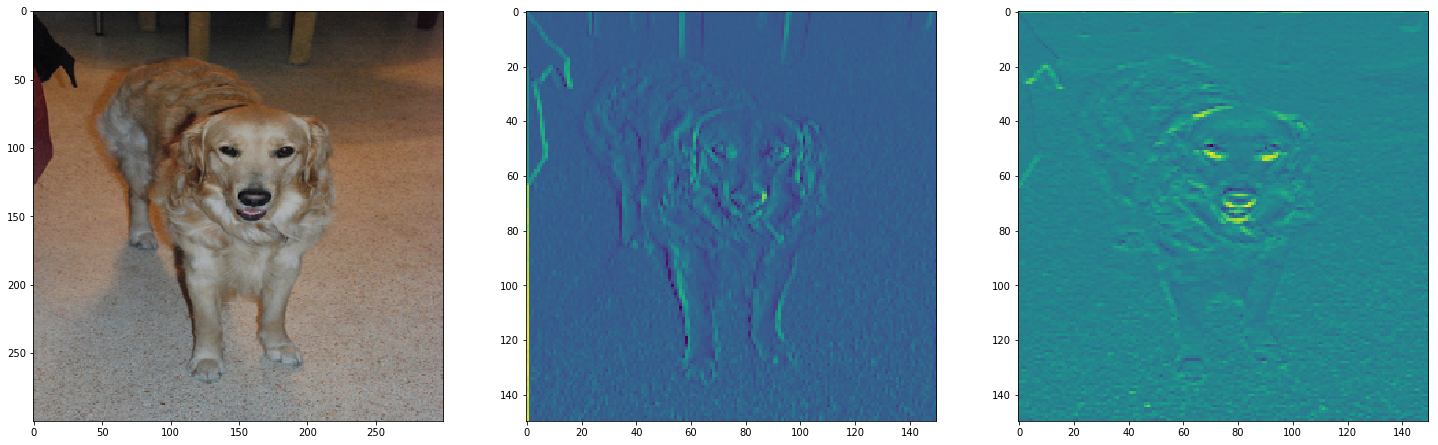

In [19]:
plt.subplots(nrows = 1, ncols = 3, figsize = (25,25))
ax = plt.subplot(131)
plt.imshow(X_train[0])

ax1 = plt.subplot(132)
plt.imshow(output_pool[0,:,:,0])


ax2 = plt.subplot(133)
plt.imshow(output_pool[0,:,:,1])
plt.savefig('images/pool_filter.jpeg', bbox_layout = 'tight')
plt.show()

In [20]:
output_pool[0,:,:,1].shape

(150, 150)

As we can see above, the results from the convolutional layer is fed into the pooling layer and we are still left with basically the same features and edges that were extracted, but now the location of these featurs have changed. The output size of the images now are 150x150. And this is the simple premise of a CNN. Filters convolved around an image searching for features and edges. I specifically choose the filters I wanted to use for this demonstration. But in the context of a real CNN, those filters will be learned during training (excluding the pooling layer). Each filter learned will be responsible for searching for specific features in various orientations 

#### Strides
-----------------------------

Until now we've gone on the priciple that we slide the filter in each direction by only 1 column or row. This doesn't have to be the case. You can increase how many positions this filter moves by designating the "strides" of the filter. The image below shows the implementation of a 3x3 filter with a stride of 2. It is now not uncommon in more recent CNNs to remove the use of a pool layer all together in favor of just increasing strides on the convolutional layer. It serves the same purpsoe of introducing invariance into the model, but now has the downside of bearing weights that need to be saved in memory and trained. This can make it computationally expensive in comparison to a pooling layer. Note: now with incorporating strides, the resulting image shape equation shown above needs to be modified. With both padding and strides, the resulting image size is now:
> $\frac{n + 2p - f}{s}$ x $\frac{n + 2p -f}{s}$

where:
* p --> padding
* f --> filter
* n --> pixel height & width
* s --> strides

<img src="images/strides.jpg" width="500" height="500"/>

 # Building A Custom TensorFlow CNN Model Class

In [9]:
class cnnModel:
    def __init__(self, savefile=None, weight_initializer = tf.contrib.layers.xavier_initializer(seed =0), learning_rate=0.01):
        
        #Create save file path variable
        self.savefile = savefile
        #Reset any current graphs
        tf.reset_default_graph()
        #Set Random Seed
        np.random.seed(0)
        
        #Print Useful Model Information
        print('Creating CNN Graph')
        print('Tensorboard Log files stored in ./tf_logs/')
        print('To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/" --port 6006')
        print('Optimizer Learning Rate: {}'.format(learning_rate))
        
        if savefile is not None:
            print('Model Save Directory: {}\n'.format(os.path.join(os.getcwd(),savefile)))
        else:
            print('WARNING: No save directory - Model and Weights will be lost after training\n')
        
        
        #Placeholders
        self.inputs = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None, 300,300,3], name = 'X'), tf.float32)
        self.labels = tf.cast(tf.placeholder(dtype = tf.float64, shape = [None,4], name = 'y'), tf.float32)
        
        #Convolutional Layer #1
        with tf.name_scope('Convolution_layer_1'):
            self.W1 = tf.get_variable(dtype = tf.float32, name = 'W1', shape = [7,7,3,10], initializer=weight_initializer)
            self.C1 = tf.nn.conv2d(input = self.inputs, filter=self.W1, strides = [1,2,2,1], padding='SAME', name = 'C1')
            self.A1 = tf.nn.relu(features = self.C1, name = 'C1')
            self.P1 = tf.nn.max_pool(self.A1, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_1')

        #Convolutional Layer #2
        with tf.name_scope('Convolution_layer_2'):
            self.W2 = tf.get_variable(dtype = tf.float32, name = 'W2', shape = [4,4,self.P1.shape[3],10], initializer=weight_initializer)
            self.C2 = tf.nn.conv2d(input = self.P1, filter = self.W2, strides = [1,2,2,1], padding = 'SAME', name = 'C2')
            self.A2 = tf.nn.relu(features = self.C2 , name = 'A2')

        #Convolutional Layer #3
        with tf.name_scope('Convolution_layer_3'):
            self.W3 = tf.get_variable(dtype = tf.float32, name = 'W3', shape = [3,3,self.A2.shape[3],20], initializer=weight_initializer)
            self.C3 = tf.nn.conv2d(input = self.A2, filter = self.W3, strides = [1,3,3,1], padding = 'SAME', name = 'C3')
            self.A3 = tf.nn.relu(features = self.C3, name = 'A3')
            self.P3 = tf.nn.max_pool(value = self.A3, ksize = [1,2,2,1], padding = 'VALID', strides = [1,2,2,1], name = 'Pool_3')

        #Fully Connected Layer
        with tf.name_scope('Fully_connected_layer'):
            self.flatten = tf.contrib.layers.flatten(self.P3)
            self.Z1 = tf.contrib.layers.fully_connected(self.flatten, num_outputs = 4, activation_fn = None)

        #Prediction Operation
        with tf.name_scope('Prediction_Op'):
            self.predictions = tf.nn.softmax(logits = self.Z1)
            
        #Training Operation   
        with tf.name_scope('Training_Op'):
            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.Z1, labels = self.labels))
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
            
            
            
        #Gloabal Variables Initializer
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        
        #Log Files for Tensorboard Viewing
        cost_summary = tf.summary.scalar('Cost', self.cost)
        weights_summary1 = tf.summary.histogram('Weights_1',self.W1)
        weights_summary2 = tf.summary.histogram('Weights_2',self.W2)
        weights_summary3 = tf.summary.histogram('Weights_3',self.W3)
        conv1_summary_channels = tf.summary.image('First_Conv_Layer',self.C1[:,:,:,0:3], max_outputs = 2)
        conv2_summary = tf.summary.image('Second_Conv_Layer',self.C2[:,:,:,0:3], max_outputs=2 )
        conv3_summary = tf.summary.image('Third_Conv_Layer',self.C3[:,:,:,0:3], max_outputs=2)
        self.merged_summaries = tf.summary.merge_all()
        
        
        
    def fit(self,x,y, num_epochs = 100, batch_size = 50):
        print('********* TRAINING MODEL *********')
        num_of_batches = int(x.shape[0] / batch_size)
        
        with tf.Session() as sess:
            #Initialize all Global Variables
            sess.run(self.init)
            #Initialize log writer for Tensorboard
            writer = tf.summary.FileWriter('tf_logs/', sess.graph)
            for i in range(num_epochs):
                #Initialize useful variables
                cost = 0
                batch_start = 0
                
                for j in range(num_of_batches):
                    #Train the model and track cost
                    _,c = sess.run([self.optimizer,self.cost], feed_dict={
                                                            self.inputs:x[batch_start:batch_start + batch_size],
                                                            self.labels:y[batch_start:batch_start + batch_size]
                                                            })
                    
                    batch_start+=batch_size
                    cost+=c
                    
                #Every 10 epochs, ,  and 
                if i%10 == 0:
                    #print the cost
                    print('Cost For Epoch {}: {}'.format(i,cost))
                    
                    #save a checkpoint of the model
                    self.saver.save(sess, self.savefile)
                    
                    #write log files for tensorboard
                    summary = sess.run(self.merged_summaries, feed_dict = {self.inputs:x, self.labels:y})
                    writer.add_summary(summary)
        
        
   
            
        
    
    
    def predict(self, x):
        with tf.Session() as sess:
            #Restore last saved model checkpoint
            self.saver.restore(sess, self.savefile)
            #Run feed forward part of the graph for predictions
            predictions = sess.run(self.predictions, feed_dict = {self.inputs:x})
            #Return Predictions
            predictions = [np.argmax(y) for y in predictions]
        return predictions

In [10]:
test = cnnModel(savefile = 'Save/my_model.ckpt')

Creating CNN Graph
Tensorboard Log files stored in ./tf_logs/
To Activate Tensorboard Session: $tensorboard --logdir "./tf_logs/" --port 6006
Optimizer Learning Rate: 0.01
Model Save Directory: /home/scott/Springboard-Data-Science-Immersive/Capstone 2 Project/Convolutional Network/Save/my_model.ckpt



In [9]:
test.fit(X_train[0:2000], y_train_v1[0:2000], batch_size = 50, num_epochs=500)

********* TRAINING MODEL *********
Cost For Epoch 0: 52.83059346675873
Cost For Epoch 10: 21.417326897382736
Cost For Epoch 20: 14.224914625287056
Cost For Epoch 30: 10.713736601173878
Cost For Epoch 40: 15.734632052481174
Cost For Epoch 50: 7.5281349159777164
Cost For Epoch 60: 19.69493681192398
Cost For Epoch 70: 10.422695979475975
Cost For Epoch 80: 8.010641888715327
Cost For Epoch 90: 11.466912470757961
Cost For Epoch 100: 7.816495269536972
Cost For Epoch 110: 5.342621909454465
Cost For Epoch 120: 6.312348117120564
Cost For Epoch 130: 10.270704300608486
Cost For Epoch 140: 1.5239968765818048
Cost For Epoch 150: 8.024421750800684
Cost For Epoch 160: 9.784801641944796
Cost For Epoch 170: 4.567426434292429
Cost For Epoch 180: 6.362437483971007
Cost For Epoch 190: 7.318101606711934
Cost For Epoch 200: 2.8592771550388534
Cost For Epoch 210: 15.738861221820116
Cost For Epoch 220: 2.7464209112067692
Cost For Epoch 230: 1.1648911880733408
Cost For Epoch 240: 0.0823469368779115
Cost For Epo

### Test the model

* **0 = Dog**
* **1 = Bird**
* **2 = Stove**
* **3 = Car**

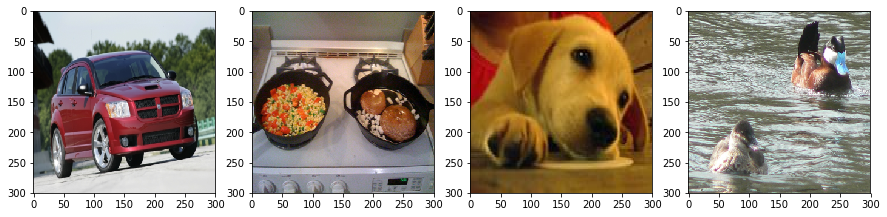

In [23]:
plt.subplots(nrows=1, ncols=4, figsize = (15,8))

ax = plt.subplot(141)
plt.imshow(X_train[91])

ax2 = plt.subplot(142)
plt.imshow(X_train[92])

ax3 = plt.subplot(143)
plt.imshow(X_train[93])

ax4 = plt.subplot(144)
plt.imshow(X_train[94])

plt.show()

In [22]:
test.predict(X_train[91:95])

INFO:tensorflow:Restoring parameters from Save/my_model.ckpt


[3, 2, 0, 1]